# Exploration of the `VIIRS_centiles` dataset
**Author:** Alex Nisnevich

This notebook introduces the VIIRS centiles dataset, which includes monthly aggregate light information for each county in the United States.

_Note:_ I'm using [https://www.census.gov/geo/reference/ansi_statetables.html](the ANSI State code list) and [](the ANSI County code lists) to decode the `GEOID`s in this dataset.

In [1]:
%matplotlib inline

import pandas as pd
import geojson
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
import shapely.geometry as geom

plt.style.use('ggplot')

/Users/alex/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## 1. Loading the dataset

Let's load the VIIRS centiles dataset.

In [2]:
counties = pd.read_csv('data/bayes_viirs_centiles.csv')
counties.shape

(49405, 106)

For now, let's just look at a single month's worth of data – say, January 2015.

In [3]:
counties_jan_2015 = counties[(counties["year"] == 2015) & (counties["month"] == 1)]
counties_jan_2015.set_index("GEOID", inplace=True)
counties_jan_2015.shape

(3220, 105)

In [4]:
counties_jan_2015.head()

,year,month,sum,pct.0,pct.1,pct.2,pct.3,pct.4,pct.5,pct.6,...,pct.92,pct.93,pct.94,pct.95,pct.96,pct.97,pct.98,pct.99,pct.100,char
GEOID,,,,,,,,,,,,,,,,,,,,,
10001,2015,1,29994.766917,0.311258,0.402101,0.423164,0.437242,0.450412,0.461987,0.475499,...,8.606541,10.267921,12.364763,15.183322,18.613616,22.652377,30.753486,39.785943,104.381218,5
10003,2015,1,83803.569815,0.371193,0.517193,0.553226,0.589921,0.625723,0.661726,0.690361,...,34.291851,36.828442,40.042993,44.273496,48.898194,54.566767,63.634828,80.867041,221.455429,5
10005,2015,1,33622.508341,0.300052,0.388232,0.411015,0.430650,0.444303,0.458321,0.470549,...,5.402310,6.083416,6.905076,7.982741,9.759915,11.872270,15.336419,21.160101,62.423729,5
1001,2015,1,12265.871061,0.132351,0.210856,0.227608,0.238019,0.246427,0.254347,0.259957,...,2.746712,3.052393,3.527545,4.260455,5.486497,7.492242,10.747479,17.912148,137.692917,4
1003,2015,1,42417.992968,0.059485,0.161577,0.176453,0.185886,0.195110,0.201965,0.208223,...,4.599915,5.368496,6.246096,7.433799,9.126484,11.522981,15.202338,24.306215,114.295418,4


Roughly how many months of data are included in the overall dataset?

In [5]:
len(counties) / len(counties_jan_2015)

15

## 2. The `sum` feature

Let's try to figure out what this `sum` feature means exactly.

What are the counties with the highest "`sum`"?

In [6]:
counties_jan_2015.sort_values('sum', ascending=False)[:10]

,year,month,sum,pct.0,pct.1,pct.2,pct.3,pct.4,pct.5,pct.6,...,pct.92,pct.93,pct.94,pct.95,pct.96,pct.97,pct.98,pct.99,pct.100,char
GEOID,,,,,,,,,,,,,,,,,,,,,
2290,2015,1,6447121.291902,0.368831,0.547778,0.587114,0.618974,0.649363,0.679980,0.710734,...,2.137763,2.175502,2.221441,2.283771,2.373250,2.500844,2.668886,3.016308,47.300632,4
2185,2015,1,5983308.772381,0.984780,1.195192,1.234529,1.261440,1.281602,1.298134,1.312850,...,2.621329,2.672404,2.726674,2.787089,2.855471,2.941780,3.066919,3.521391,915.061462,4
2188,2015,1,2502009.859271,1.262065,1.657667,1.711645,1.750241,1.778757,1.801985,1.821886,...,2.514804,2.541722,2.572862,2.608643,2.652552,2.709009,2.791560,2.940658,87.644058,4
17031,2015,1,1122808.764947,3.290548,4.747416,5.598044,6.500326,7.451701,8.387699,9.390355,...,181.714188,187.174122,192.514169,198.951641,206.573322,217.028257,234.982036,261.550345,565.837219,5
2240,2015,1,1033640.511017,0.691974,0.989391,1.040067,1.072409,1.098691,1.120834,1.140289,...,1.828571,1.848034,1.870283,1.895258,1.926184,1.969319,2.043561,2.466713,71.165405,4
2180,2015,1,959673.849639,0.503118,0.701703,0.727093,0.744188,0.758924,0.772731,0.787087,...,1.870710,1.902605,1.934605,1.964705,1.992128,2.021386,2.067832,2.163585,40.582764,4
6037,2015,1,862957.692351,0.072532,0.157501,0.188446,0.207630,0.219077,0.228426,0.237242,...,54.316761,57.698040,61.566090,66.080414,71.839806,79.146645,90.478844,114.150539,467.639435,4
48201,2015,1,853758.196986,0.383562,0.691844,0.827261,0.964208,1.123763,1.281958,1.419821,...,87.986967,92.745249,98.717109,105.804179,113.679274,125.535592,142.516143,169.836955,418.676605,5
2261,2015,1,847877.278971,0.135744,0.300037,0.320786,0.335084,0.346881,0.357435,0.367345,...,1.351260,1.376314,1.404428,1.434142,1.467873,1.505816,1.553454,1.628119,82.512413,4


Looks like most of them are in Alaska (02 = AK). I guess the high latitude can explain that. Not counting the Alaska ones, the highest are 17031 (17 = IL, 031 = Cook County) and 6037 (06 = CA, 037 = Los Angeles County), which are also the two most populous counties in the United States!

Hey, that's interesting. So it looks like `sum` is a measure of total light area (rather than light density – in that case, New York and San Francisco would score more highly than Chicago and Los Angeles), and is a reasonably good proxy measure for population.

## 3. Light Area and Light Density Maps 

Let's try to plot light _area_ and light _density_ maps for an individual state – say, California.

First, let's load a GeoJSON file containing polygons corresponding to each county in the country (you can also try `us_counties_5m.json`, which has much finer resolution but at the cost of longer processing time).

In [7]:
with open("data/util/us_counties_500k.json") as json_file:
    counties_geo = geojson.loads(json_file.read().decode("ISO-8859-1"))

Let's construct a dictionary containing the polygons, light `sum` measurement, and area (just computed from the shape of the polygons themselves) for each county in California:

In [8]:
counties_to_plot = []
for county in counties_geo["features"]:
    if county["properties"]["STATE"] == '06': # California
        county_code = int(county["properties"]["STATE"] + county["properties"]["COUNTY"])
        light = counties_jan_2015.loc[county_code]['sum']
        polygon = county["geometry"]
        area = geom.shape(polygon).area
        
        polygons = []
        if polygon["type"] == 'MultiPolygon':
            for subpoly in polygon["coordinates"]:
                polygons.append({"type": "Polygon", "coordinates": subpoly})
        else:
            polygons.append(polygon)
            
        counties_to_plot.append({"polygons": polygons, "light": light, "area": area})

Alright, time to do some plotting!

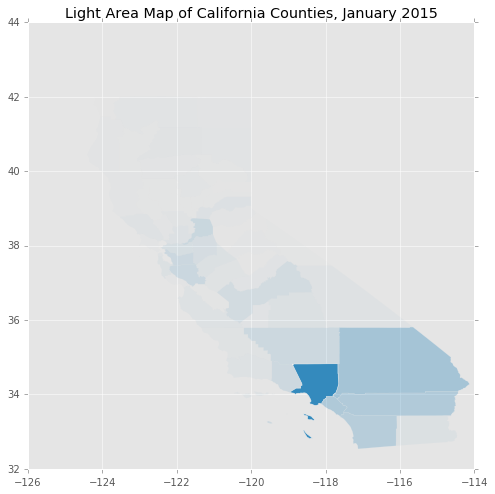

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

max_alpha = max(map(lambda c: c['light'], counties_to_plot))
for county in counties_to_plot:
    for poly in county["polygons"]:
        ax.add_patch(PolygonPatch(poly, alpha=county["light"] / max_alpha))
 
ax.set_title('Light Area Map of California Counties, January 2015')
_ = ax.axis('scaled')

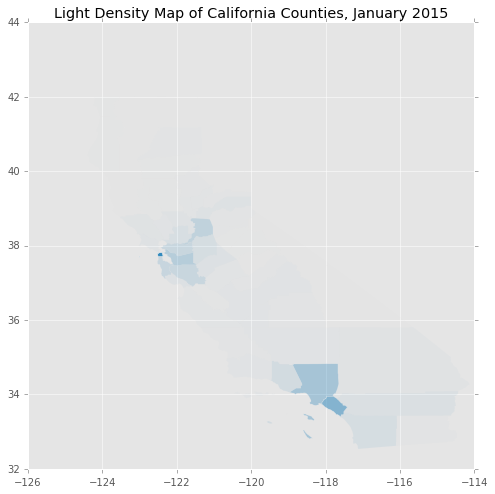

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

max_alpha = max(map(lambda c: c['light'] / c['area'], counties_to_plot))
for county in counties_to_plot:
    for poly in county["polygons"]:
        ax.add_patch(PolygonPatch(poly, alpha=(county["light"] / county["area"]) / max_alpha))
 
ax.set_title('Light Density Map of California Counties, January 2015')
_ = ax.axis('scaled')

## 4. Counties with rising and falling light intensity

Let's see which counties have increasing and decreasing in light intensity the most over the past year.

First, we need to pivot by date on the `sum` column to get historical data for each county.

In [11]:
counties['date'] = counties.year.map(str) + "-" + counties.month.map(str)
pivoted = counties.pivot(index='GEOID', columns='date', values='sum')

In [12]:
pivoted

date,2014-10,2014-11,2014-12,2014-2,2014-3,2014-4,2014-5,2014-6,2014-7,2014-8,2014-9,2015-1,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8
GEOID,,,,,,,,,,,,,,,,,,,
1001,10861.028656,10575.209902,12266.614637,8440.666222,11553.459427,10165.781657,11320.262031,9768.491513,10435.464466,9922.752522,10043.155801,12265.871061,10827.021597,10854.946070,10906.886884,9533.662811,10832.693553,9647.853946,8196.362634
1003,40315.610298,39806.133362,38418.785405,38116.008635,44307.036144,40329.093102,41129.918652,35704.141356,38184.915005,35621.191023,37480.906825,42417.992968,40511.665659,43494.827594,39618.642664,38887.535307,35644.781113,36075.540704,32511.645639
1005,7902.602958,6451.366160,8210.419898,8614.756428,8672.950001,7815.851306,7748.501871,5882.823691,6871.583857,6845.875173,6863.554947,8668.562269,8858.280180,8372.197973,7109.598148,6640.221430,6237.452319,6324.800255,4847.248421
1007,4953.621601,4243.345847,5486.643082,5017.441329,5082.603282,5874.210665,5277.119278,4275.192767,4142.102741,4116.814611,4047.841156,5975.963289,6139.792051,5231.659150,6116.858561,4706.135476,5170.218105,4043.166156,2780.841645
1009,8770.632164,8275.258406,10000.614134,8128.820514,8290.557094,9960.467057,8718.316469,3189.324113,8057.377934,7431.406219,7553.363311,9097.222242,9548.308974,7205.698830,10086.391066,8386.169448,NaN,6935.622986,5859.214446
1011,3685.452237,2697.290391,3909.328509,3829.389820,4345.604603,3752.936931,4016.545397,2289.634012,3278.016411,3322.043834,3016.244658,3646.901902,4531.134731,3705.417357,3902.784666,2936.559239,2867.208239,2983.637897,1602.863258
1013,5553.550498,4502.764615,6404.603771,6019.597426,6171.725387,5215.946439,5912.566946,4729.840487,4855.342953,5147.260742,4500.474606,6250.215262,6591.976874,5756.520412,5486.590745,5075.556226,4469.261925,4787.660782,3223.153931
1015,25421.707864,26698.188904,25003.698703,22577.134471,25899.876135,25196.944977,24511.915548,5061.324027,24423.451178,21440.205610,22728.219126,23646.011771,23779.952602,20937.625782,25028.982317,23387.159617,NaN,21546.048107,21287.394451
1017,8221.692615,7553.984782,8270.076507,7981.161980,8727.932894,8048.335349,8398.807188,6801.145238,7823.378662,7422.744897,6973.846128,9049.459080,8619.770137,8692.853461,8598.201363,7671.914215,7918.749537,6613.835917,5660.784436


Which counties have increased their light intensity the most over the past year?

In [13]:
pct_change_over_past_year = (pivoted["2015-8"] - pivoted["2014-8"]) / pivoted["2014-8"]

In [14]:
pct_change_over_past_year.sort_values(ascending=False)[:10]

GEOID
48495    3.413907
48109    1.827214
27147    1.495293
48461    1.470688
6015     1.465497
16029    0.961586
6105     0.947501
48389    0.853577
22121    0.820449
27011    0.607397
dtype: float64

Looks like they're mostly in Texas (48), Minnesota (27), and California (06).

Which counties have decreased their light intensity the most over the past year?

In [15]:
pct_change_over_past_year.sort_values(ascending=True)[:10]

GEOID
35003   -1.545560
48243   -1.438621
35011   -1.410247
48043   -1.338724
35021   -1.334391
48377   -1.321397
48443   -1.321295
48327   -1.288269
35051   -1.269010
35033   -1.245150
dtype: float64

Looks like they're mostly in New Mexico (35), and also in Texas (48). Interesting.

Let's look at some basic statistics for this `pct_change_over_past_year` variable:

In [16]:
pct_change_over_past_year.describe()

count    2960.000000
mean       -0.275414
std         0.282352
min        -1.545560
25%        -0.401074
50%        -0.220014
75%        -0.093026
max         3.413907
dtype: float64

Interesting. It looks like the majority of counties are decreasing in light intensity, according to this. That's kind of strange – I would have expected it to be the other way around.

## 5. What about those `pct.` features?

The `pct.0` through `pct.100` features were described to me as "the number of pixels in a given county with a light intensity at the Nth percentile". In other words, `pct.100` is the number of pixels in a county whose light intensity is in the top 1% of all pixels, and so on.

It's not entirely clear to me how these features work, but the graphs below give a sense of what the light intensity distribution graph looks like for a highly dense urban county (e.g. San Francisco), and spread-out urban county (e.g. Los Angeles), and a rural county (e.g. Kern).

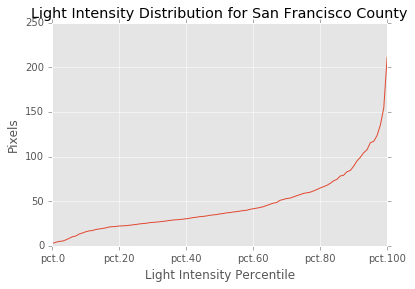

In [17]:
ax = counties_jan_2015.ix[6075,3:104].plot()
ax.set_xlabel("Light Intensity Percentile")
ax.set_ylabel("Pixels")
_ = ax.set_title("Light Intensity Distribution for San Francisco County")

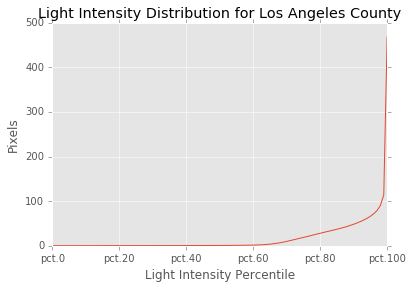

In [18]:
ax = counties_jan_2015.ix[6037,3:104].plot()
ax.set_xlabel("Light Intensity Percentile")
ax.set_ylabel("Pixels")
_ = ax.set_title("Light Intensity Distribution for Los Angeles County")

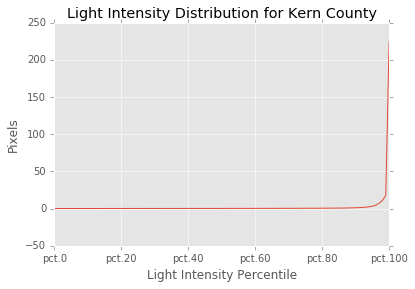

In [19]:
ax = counties_jan_2015.ix[6029,3:104].plot()
ax.set_xlabel("Light Intensity Percentile")
ax.set_ylabel("Pixels")
_ = ax.set_title("Light Intensity Distribution for Kern County")